In [9]:
import sed_vis
import dcase_util
import sys

sys.path.append("../")
from trainer import SED

import torch
import yaml
from encoder import ManyHotEncoder
from utils import classes_labels
from model import CRNN
import pandas as pd
from desed_task.dataio.datasets import StronglyAnnotatedSet
from utils import batched_decode_preds
import numpy as np
import IPython.display as ipd

In [4]:
with open("../params.yaml", "r") as f:
    config = yaml.safe_load(f)

encoder = ManyHotEncoder(
    list(classes_labels.keys()),
    audio_len=config["data"]["audio_max_len"],
    frame_len=config["feats"]["n_filters"],
    frame_hop=config["feats"]["hop_length"],
    net_pooling=config["data"]["net_subsample"],
    fs=config["data"]["fs"],
)

sed = SED(config, encoder=encoder, sed=CRNN(**config["net"]))
print(sed.state_dict().keys())

# path = "../dvclive/artifacts/epoch=27-step=23352.ckpt"
# path = "../dvclive/artifacts/epoch=58-step=12449.ckpt"
path = "../dvclive/artifacts/epoch=68-step=7314.ckpt"
state_dict = torch.load(path, map_location=torch.device("cpu"))["state_dict"]
sed.load_state_dict(state_dict)

tsv_entries_strong = pd.read_csv(config["data"]["test_tsv"], sep="\t")
dataset_strong = StronglyAnnotatedSet(
    audio_folder=config["data"]["test_folder"],
    tsv_entries=tsv_entries_strong,
    encoder=encoder,
    return_filename=True,
    pad_to=config["data"]["audio_max_len"],
)

odict_keys(['sed.cnn.cnn.conv0.weight', 'sed.cnn.cnn.conv0.bias', 'sed.cnn.cnn.batchnorm0.weight', 'sed.cnn.cnn.batchnorm0.bias', 'sed.cnn.cnn.batchnorm0.running_mean', 'sed.cnn.cnn.batchnorm0.running_var', 'sed.cnn.cnn.batchnorm0.num_batches_tracked', 'sed.cnn.cnn.conv1.weight', 'sed.cnn.cnn.conv1.bias', 'sed.cnn.cnn.batchnorm1.weight', 'sed.cnn.cnn.batchnorm1.bias', 'sed.cnn.cnn.batchnorm1.running_mean', 'sed.cnn.cnn.batchnorm1.running_var', 'sed.cnn.cnn.batchnorm1.num_batches_tracked', 'sed.cnn.cnn.conv2.weight', 'sed.cnn.cnn.conv2.bias', 'sed.cnn.cnn.batchnorm2.weight', 'sed.cnn.cnn.batchnorm2.bias', 'sed.cnn.cnn.batchnorm2.running_mean', 'sed.cnn.cnn.batchnorm2.running_var', 'sed.cnn.cnn.batchnorm2.num_batches_tracked', 'sed.cnn.cnn.conv3.weight', 'sed.cnn.cnn.conv3.bias', 'sed.cnn.cnn.batchnorm3.weight', 'sed.cnn.cnn.batchnorm3.bias', 'sed.cnn.cnn.batchnorm3.running_mean', 'sed.cnn.cnn.batchnorm3.running_var', 'sed.cnn.cnn.batchnorm3.num_batches_tracked', 'sed.cnn.cnn.conv4.weigh

In [53]:
sed(dataset_strong[0][0])

tensor([[[0.0581, 0.0684, 0.0700,  ..., 0.1445, 0.1592, 0.1017],
         [0.0485, 0.0179, 0.0177,  ..., 0.0489, 0.0508, 0.0315],
         [0.0142, 0.0250, 0.0074,  ..., 0.0882, 0.0164, 0.0158],
         ...,
         [0.2524, 0.2459, 0.2716,  ..., 0.2747, 0.1657, 0.2489],
         [0.0495, 0.0643, 0.1784,  ..., 0.4138, 0.2034, 0.2675],
         [0.0473, 0.0707, 0.0409,  ..., 0.0334, 0.0662, 0.0278]]],
       grad_fn=<TransposeBackward0>)

In [54]:
# i = 39
i = 221
preds = batched_decode_preds(sed(dataset_strong[i][0]), dataset_strong[i][3], encoder)
print(dataset_strong[i][3])
preds[2][0.5][["onset", "offset", "event_label"]].to_csv(
    "preds.tsv", index=False, sep="\t"
)
preds[2][0.5][["onset", "offset", "event_label"]]

/mnt/d/DESED_dataset/audio/validation/validation_16k/YQmGZDxks87s_100.000_110.000.wav


,onset,offset,event_label
0,5.440,6.448,Speech
1,6.912,9.456,Speech
2,1.952,1.968,Vacuum_cleaner
3,2.000,2.032,Vacuum_cleaner
4,2.048,2.064,Vacuum_cleaner
5,2.080,2.112,Vacuum_cleaner
6,2.208,2.240,Vacuum_cleaner
7,2.256,2.432,Vacuum_cleaner
8,2.992,3.008,Vacuum_cleaner
9,3.024,3.072,Vacuum_cleaner


In [55]:
ref_df = pd.read_csv(config["data"]["test_tsv"], sep="\t")
ref_df = (
    ref_df[ref_df["filename"] == dataset_strong[i][3].split("/")[-1]]
    .reset_index()
    .drop(columns=["index"])
)
ref_df.drop("filename", axis=1).to_csv("ref.tsv", index=False, sep="\t")
ref_df

,filename,onset,offset,event_label
0,YQmGZDxks87s_100.000_110.000.wav,0.000,9.983,Running_water
1,YQmGZDxks87s_100.000_110.000.wav,5.306,6.588,Speech
2,YQmGZDxks87s_100.000_110.000.wav,6.753,9.494,Speech


In [56]:
# Load audio signal first
audio_container = dcase_util.containers.AudioContainer().load(
    f"/mnt/d/DESED_dataset/audio/validation/validation_16k/{dataset_strong[i][3].split('/')[-1]}"
)
audio_container.data = np.mean(audio_container.data, axis=0)

In [57]:
audio_container.data.shape

(160000,)

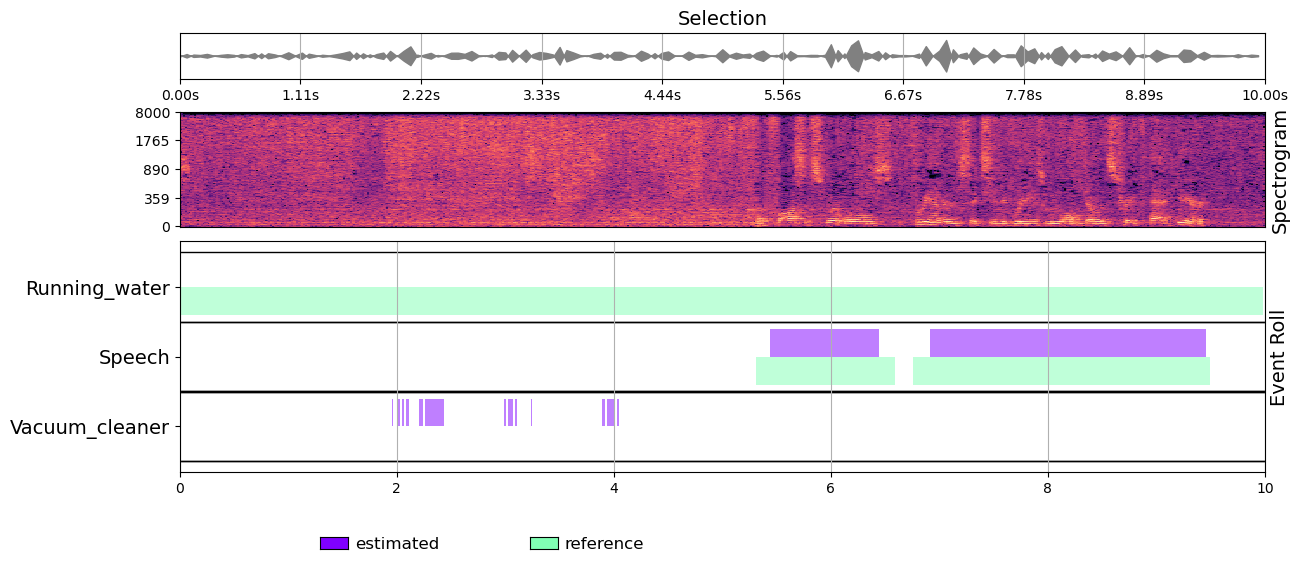

In [58]:
# Load event lists
reference_event_list = dcase_util.containers.MetaDataContainer().load("ref.tsv")
estimated_event_list = dcase_util.containers.MetaDataContainer().load("preds.tsv")

event_lists = {"reference": reference_event_list, "estimated": estimated_event_list}

# Visualize the data
vis = sed_vis.visualization.EventListVisualizer(
    event_lists=event_lists,
    audio_signal=audio_container.data,
    sampling_rate=audio_container.fs,
)
try:
    vis.show()
except:
    pass

In [59]:
ipd.Audio(audio_container.data, rate=audio_container.fs)

# Exp


In [10]:
def inference(
    idx, model_path="../dvclive/artifacts/epoch=68-step=7314.ckpt", print_df=False
):
    with open("../params.yaml", "r") as f:
        config = yaml.safe_load(f)

    encoder = ManyHotEncoder(
        list(classes_labels.keys()),
        audio_len=config["data"]["audio_max_len"],
        frame_len=config["feats"]["n_filters"],
        frame_hop=config["feats"]["hop_length"],
        net_pooling=config["data"]["net_subsample"],
        fs=config["data"]["fs"],
    )

    sed = SED(config, encoder=encoder, sed=CRNN(**config["net"]))
    # print(sed.state_dict().keys())

    state_dict = torch.load(model_path, map_location=torch.device("cpu"))["state_dict"]
    sed.load_state_dict(state_dict)

    tsv_entries_strong = pd.read_csv(config["data"]["test_tsv"], sep="\t")
    dataset_strong = StronglyAnnotatedSet(
        audio_folder=config["data"]["test_folder"],
        tsv_entries=tsv_entries_strong,
        encoder=encoder,
        return_filename=True,
        pad_to=config["data"]["audio_max_len"],
    )

    preds = batched_decode_preds(
        sed(dataset_strong[idx][0]), dataset_strong[idx][3], encoder
    )
    # print(dataset_strong[i][3])
    preds[2][0.5][["onset", "offset", "event_label"]].to_csv(
        "preds.tsv", index=False, sep="\t"
    )

    if print_df:
        print("--------Preds--------")
        print(preds[2][0.5][["onset", "offset", "event_label"]])

    ref_df = pd.read_csv(config["data"]["test_tsv"], sep="\t")
    ref_df = (
        ref_df[ref_df["filename"] == dataset_strong[idx][3].split("/")[-1]]
        .reset_index()
        .drop(columns=["index"])
    )
    ref_df.drop("filename", axis=1).to_csv("ref.tsv", index=False, sep="\t")

    if print_df:
        print("--------Ref--------")
        print(ref_df)

    audio_container = dcase_util.containers.AudioContainer().load(
        f"/mnt/d/DESED_dataset/audio/validation/validation_16k/{dataset_strong[idx][3].split('/')[-1]}"
    )
    audio_container.data = np.mean(audio_container.data, axis=0)

    # Load event lists
    reference_event_list = dcase_util.containers.MetaDataContainer().load("ref.tsv")
    estimated_event_list = dcase_util.containers.MetaDataContainer().load("preds.tsv")

    event_lists = {"reference": reference_event_list, "estimated": estimated_event_list}

    # Visualize the data
    vis = sed_vis.visualization.EventListVisualizer(
        event_lists=event_lists,
        audio_signal=audio_container.data,
        sampling_rate=audio_container.fs,
    )
    try:
        vis.show()
    except:
        pass

    return audio_container.data, audio_container.fs

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM sysdefault
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No

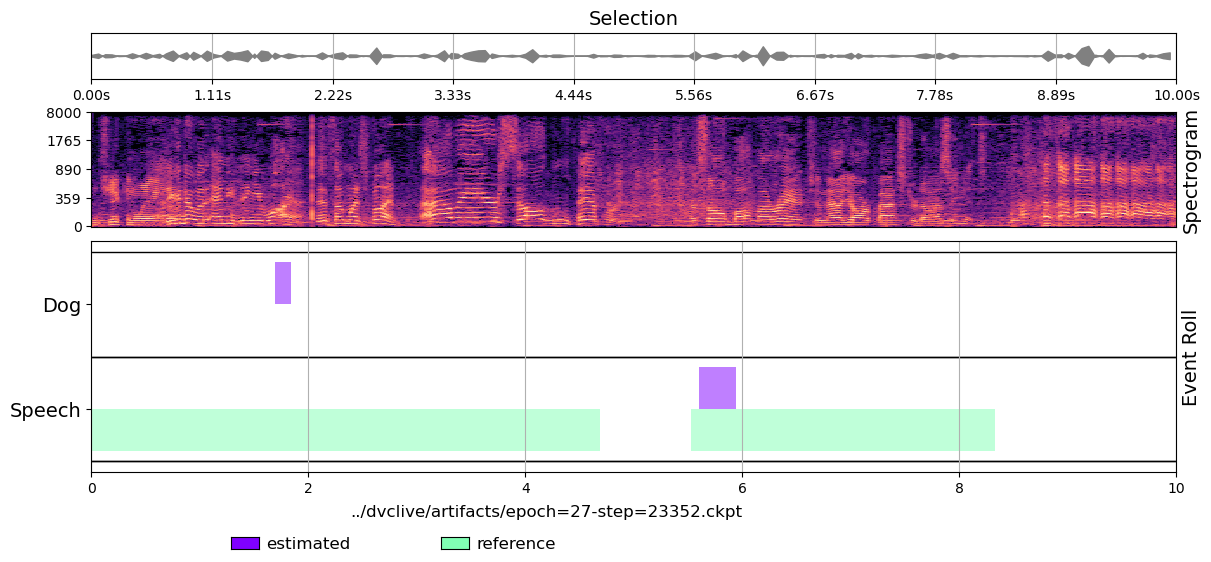

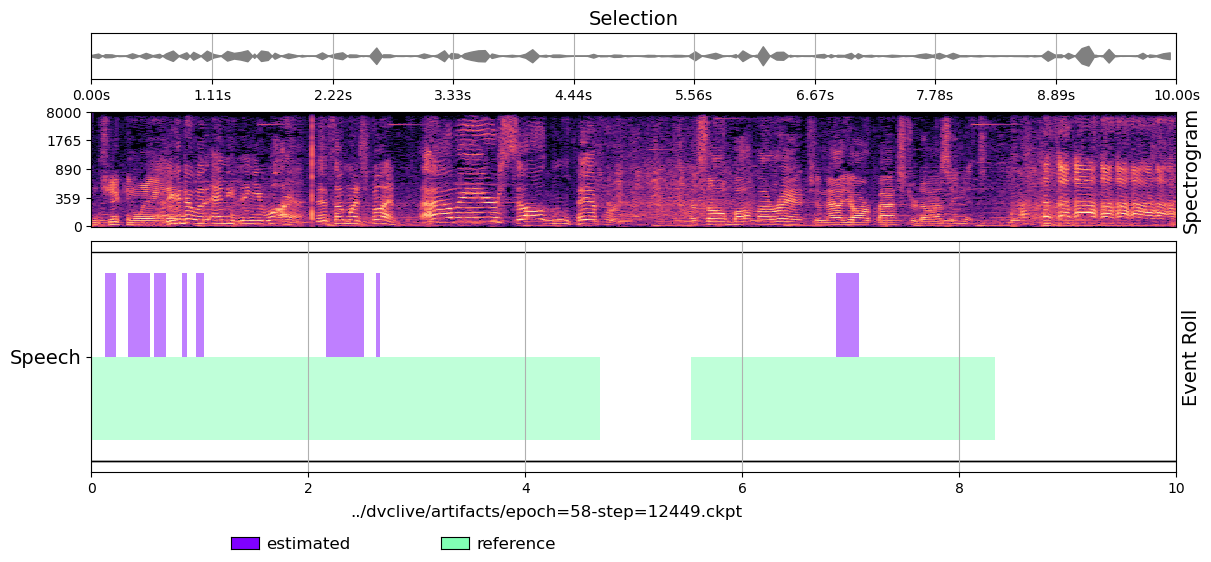

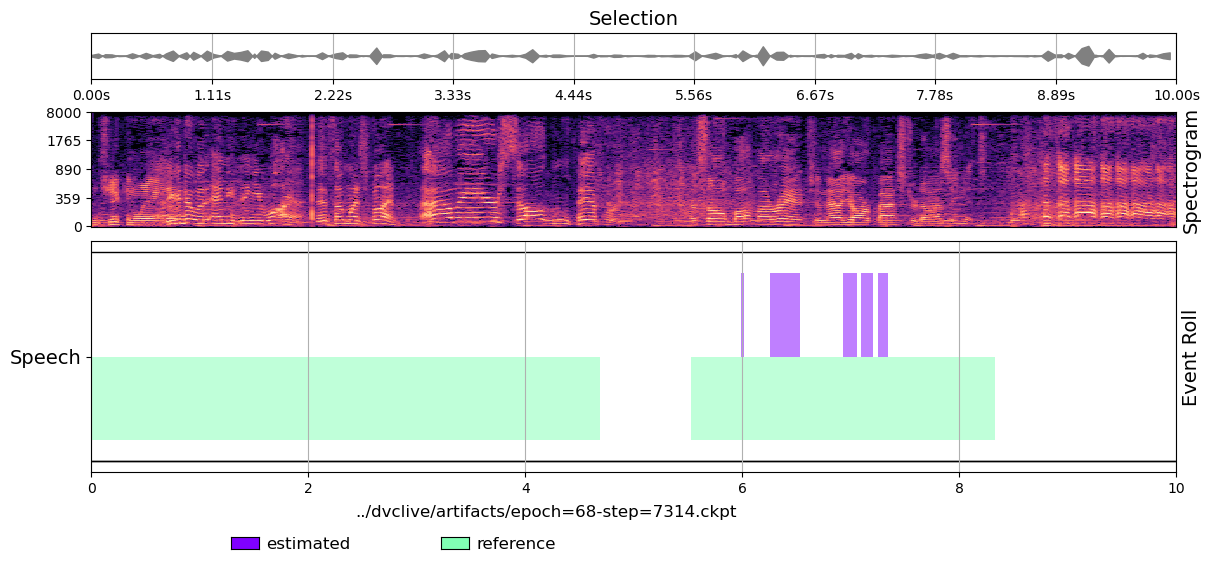

In [12]:
import matplotlib.pyplot as plt
import random

models = [
    "../dvclive/artifacts/epoch=27-step=23352.ckpt",
    "../dvclive/artifacts/epoch=58-step=12449.ckpt",
    "../dvclive/artifacts/epoch=68-step=7314.ckpt",
]

idx = random.randint(0, len(dataset_strong) - 1)  # 544

for model in models:
    audio, fs = inference(idx, model)
    plt.title(model)
ipd.Audio(audio, rate=fs)